# CS 6476 Project 3: Local Feature Matching

## Brief
- Due
    - [Gradescope Group Quiz](https://www.gradescope.com/courses/155064/assignments/753851) Due: 10/21/2020 11:59PM
    - Full Assignment (Individual only) - 10/28/2020 11:59PM
- Hand-in: through Gradescope
- Required files: 
    - `<your_gt_username>.zip` to [Project 3 - Code](https://www.gradescope.com/courses/155064/assignments/753748)
    - `<your_gt_username>.pdf` to [Project 3 - Report](https://www.gradescope.com/courses/155064/assignments/753849)


## Outline
The goal of this assignment is to create a local feature matching algorithm using techniques described in Szeliski chapter 4.1. The pipeline we suggest is based on a simplified version of the famous SIFT pipeline. However, we will not be implementing this in the classical fashion. We will be implementing it as though it were part of a neural network. The matching pipeline is intended to work for instance-level matching – multiple views of the same physical scene.

This project is intended to further familiarize you with Python, PyTorch, and local feature matching. Once again, you may find these resources helpful. Python: [here](https://docs.python.org/3/tutorial/). PyTorch: [here](https://pytorch.org/tutorials/).

## Gradescope Group Quiz
The instructors feel like this semester being remote, has us all feeling a bit isolated, and we'd like to introduce a small group activity for you all. This is going to be a short 5 question quiz available on Gradescope, and all these questions can be answered simply by reading the contents of this notebook. 

You have been randomly assigned other students from the class as a part of your group, you should be able to see this on Canvas. You are welcome to discuss the answers together, and make the submission together as a group. Also, we need to see a screenshot of you guys on a group call in your Project 3 report! So, don't forget to take one!

P.S. If a group member isn't answering (or is auditing the course, and not working on projects), you can just mention it in the report and there won't be a penalty.

To ensure that you have read through the notebook sections and understand some of the concepts before coding, we will have you turn in a quiz in gradescope that will be completed with assigned groups.It can be found here: [Quiz](https://www.gradescope.com/courses/155064/assignments/753851). Please meet up with your group, and take a screenshot of the virtual meeting (any medium you choose) and include it in your report. 

**Note that the rest of the project should be done individually. You should only collaborate together for the quiz. There are no pair submissions for this project**. Feel free to discuss any concepts with each other afterward though 

## Setup

The following cell will perform some setup operations, including loading an image pair, converting it to grayscale, resizing it, and converting it into the tensor format we will use. 

### Data 
We provide you with 3 pairs of pictures of the Notre Dame, Mt. Rushmore, and the Episcopal Palace(which we refer to as Gaudi). Each image in a pair is of the same object but from a slightly different viewpoint, and was taken under differing conditions. These images will be run through the entire local feature matching pipeline, first extracting interest points, then extracting features, and finally feature matching to get correspondences across images. The image at the top of the page is what the final evaluation looks like. Interest points are matched across images and correct ones (according to an annotated ground truth) are marked with green lines and incorrect with red. You are also free to test images of your own, you will just have to annotate them with a script we provide you with in the annotate_correspondences folder.

Your accuracy on the Notre Dame image pair must be at least 80% for the 100 most confident matches to receive full credit!

**IMPORTANT NOTE**:
To test on different image pairs, simply comment in the lines corresponding to the desired image pair. By default, we load the Notre Dame image pair. We have also provided unit tests in the notebook for many of the methods, but be advised that they are fairly simple tests, and may not catch everything. The best way to check your implementations is through the results. Are the interest points where you expect, etc. **Implementations that achieve >80% accuracy(Notre Dame) will receive full credit on the code portion.** 

In [27]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np

from proj3_code.utils import load_image, PIL_resize, rgb2gray
from IPython.core.debugger import set_trace
import torch
import torchvision
import torchvision.transforms as transforms

# Notre Dame
# image1 = load_image('../data/1a_notredame.jpg')
# image2 = load_image('../data/1b_notredame.jpg')
# eval_file = '../ground_truth/notredame.pkl'

# # Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, though)
# image1 = load_image('../data/2a_rushmore.jpg')
# image2 = load_image('../data/2b_rushmore.jpg')
# eval_file = '../ground_truth/rushmore.pkl'

# # Episcopal Gaudi -- This pair is relatively difficult
image1 = load_image('../data/3a_gaudi.jpg')
image2 = load_image('../data/3b_gaudi.jpg')
eval_file = '../ground_truth/gaudi.pkl'

scale_factor = 0.5
image1 = PIL_resize(image1, (int(image1.shape[1]*scale_factor), int(image1.shape[0]*scale_factor)))
image2 = PIL_resize(image2, (int(image2.shape[1]*scale_factor), int(image2.shape[0]*scale_factor)))

image1_bw = rgb2gray(image1)
image2_bw = rgb2gray(image2)

#convert images to tensor
tensor_type = torch.FloatTensor
torch.set_default_tensor_type(tensor_type)
to_tensor = transforms.ToTensor()

image_input1 = to_tensor(image1_bw).unsqueeze(0)
image_input2 = to_tensor(image2_bw).unsqueeze(0)

%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# Part 1: Harris Corner Detector - Getting Interest Points
**NOTE**
Before starting this part, it is highly recommended that you read up on the Harris Corner Detector in the slides/book(Szeliski 4.1.1) and understand the steps it goes through. 

## HarrisNet
![HarrisNet Architecture](https://dellaert.github.io/19F-4476/images/proj2/HarrisNet.png)

The original Harris corner detector is described in the lecture materials and Szeliski 4.1.1. See Algorithm 4.1 in the textbook for pseudocode. You do not need to worry about scale invariance or keypoint orientation estimation for your baseline Harris corner detector. The original paper by Chris Harris and Mike Stephens describing their corner detector can be found [here](http://www.bmva.org/bmvc/1988/avc-88-023.pdf). We will be implementing the Harris detector using a Neural Network - HarrisNet. Our network has 5 layers (all of which you will have to implement unless instructed otherwise), described briefly below:
- **ImageGradientsLayer**
    -  retrieves image gradients in each direction. This layer is *already implemented* for you.
- **ChannelProductLayer**
    -  returns product between channels of the previous layer: Ixx, Iyy and Ixy.
- **SecondMomentMatrixLayer**
    -  computes the Second Moment Matrix.
- **CornerResponseLayer**
    -  computes the R cornerness matrix over the entire image.
- **NMSLayer**
    -  performs non-maxima suppression to keep only the strongest corners in local regions.


**TODO 1**: Fill in code for each of the layers in HarrisNet.py, and verify that the following tests pass. 


In [10]:
## Verify each layer in the code, this will check if your implementation is correct or not.

## Do not modify the constructor of any layer (i.e. to take some custom arguments
## as input)

from proj3_unit_tests.harris_unit_test import (
    test_ImageGradientsLayer,
    test_ChannelProductLayer, 
    test_SecondMomentMatrixLayer, 
    test_CornerResponseLayer, 
    test_NMSLayer,
    test_get_interest_points,
    verify
)


print('ImageGradientsLayer:', verify(test_ImageGradientsLayer))
print('ChannelProductLayer:', verify(test_ChannelProductLayer))
print('SecondMomentMatrixLayer:', verify(test_SecondMomentMatrixLayer))
print('CornerResponseLayer:', verify(test_CornerResponseLayer) )
print('NMSLayer:', verify(test_NMSLayer))


print('test_get_interest_points', verify(test_get_interest_points))





ImageGradientsLayer: "Correct"
ChannelProductLayer: "Correct"
SecondMomentMatrixLayer: "Correct"
CornerResponseLayer: "Correct"
NMSLayer: "Correct"
test_get_interest_points "Correct"


In [28]:
from proj3_code.HarrisNet import get_interest_points, remove_border_vals

After passing images through the entire network, we still need to extract specific coordinates as our interest points, which is done through get_interest_points() (you will implement this) in HarrisNet.py. Some interest points will be too close to the border and won't let us extract a feature from them in SIFTNet, so you also need to fill in remove_border_vals() to filter these out.

**TODO 2**
Fill in code for get_interest_points(), and remove_border_vals() in HarrisNet.py, and make sure remove_border_vals is called from get_interest_points. 

The following cell will run your implementation, and extract interest points for the image pair

<IPython.core.display.Javascript object>


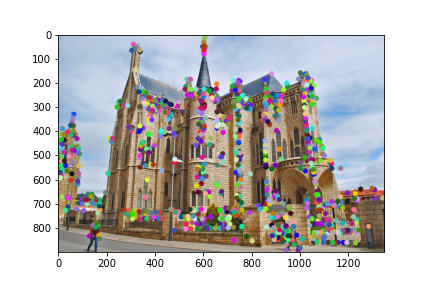

<IPython.core.display.Javascript object>


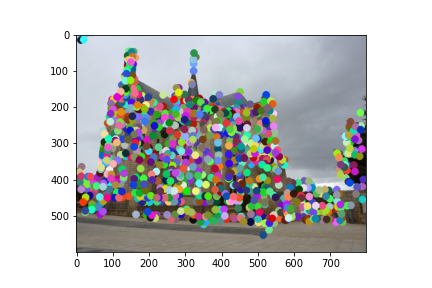

988 corners in image 1, 965 corners in image 2


In [29]:
from utils import show_interest_points

x1, y1, _ = get_interest_points(image_input1)
x2, y2, _ = get_interest_points(image_input2)

x1, x2 = x1.detach().numpy(), x2.detach().numpy()
y1, y2 = y1.detach().numpy(), y2.detach().numpy()

# Visualize the interest points
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.figure(); plt.imshow(c1)
plt.figure(); plt.imshow(c2)
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))




These visualizations should go in the report

# Part 2: Sift Feature Descriptor
**NOTE**
Before starting this part, it is highly recommended that you read up on SIFT features in the slides/book and understand the steps it goes through. 

## SiftNet
![SiftNet Architecture](https://dellaert.github.io/19F-4476/images/proj2/SIFTNet.png)

You will implement a SIFT-like local feature based on the lecture materials and Szeliski 4.1.2. We will be implementing Sift using a neaural network - SIFTNet. This network has 4 layers (which you will have to implement unless specified otherwise), described briefly below:

- **ImageGradientsLayer**
    -  retrieves image gradients in each direction. This layer is already implemented for you.
- **SIFTOrientationLayer**
    -  extracts gradient information along each orientation direction. In the original SIFT, we would be trying to find the contributions of our gradients to each orientation bin. Note that we can do this by trying to find the contribution of each gradient along each orientation vector, which is the same as finding the projection of our gradients onto our orientation vectors. Recall that this can be done using dot products! 
- **HistogramLayer**
    -  creates weighted histograms over the entire image.
- **SubGridAccumulationLayer**
    -   creates feature vectors that accumulate histograms from a region.

### SIFTOrientationLayer
**You will need to complete angles_to_vectors_2d_pytorch(), get_orientation_bin_weights(), and the init method of this layer**. angles_to_vectors_2d_pytorch() will convert angles to their 2-d basis vectors that they correspond to. Get_orientation_bin_weights() will create the weight parameters for the convolution in this layer, using angles_to_vectors_2d_pytorch(). The init method will be used to create the convolutional layer and set its weights, using get_orientation_bin_weights(). The output of this layer should have 10 channels, where the first 8 represent cosines values of angles between unit circle basis vectors and image gradient vectors, at every pixel. The last two channels will represent the
(dx, dy) coordinates of the image gradient at this pixel.

### HistogramLayer
This layer will create a weighted histogram pixelwise over the entire image. At each pixel location, there is an associated 8-dim histogram representing that pixel's contribution to the direction it most aligned with. If it aligns most with the first orientation, the gradient contributes to only that direction. Further implementation details for this can be found in the layer's description in SIFTNet.py. **You will need to fill in the forward() method in this layer.**

### SubGridAccumulationLayer
In this layer we take the histograms previously created, and accumulate the histograms in 4x4 subgrids. We do this accumulation with the use of convolution with specific weights. This layer will create accumulated histograms for each pixel based on the 4x4 window around it. **You will need to complete the init method of this layer.**

A small example is given here to help you understand what happens in SIFTNet. Let's say that the x,y gradient for a given pixel P is (5, 2). SIFTOrientationLayer will compute the projection of this gradient along each of the 8 directions (pi/8, 3pi/8, ..., 15pi/8). In Addition it will copy over the gradient magnitudes in the x,y direction for later use. The result of this would be a 10-dimensional vector where the first 8 channels correspond to the projections, and the last 2 just copy over 5 for dx and 2 for dy. This would happen for every pixel. Moving into the HistogramLayer, we now construct a histograms for each pixel. For the same pixel P we just considered, the direction the gradient aligns with the most based on the projections is pi/8, so that's the only bin that contains a value for this  pixel, where the value is the magnitude of the gradient. The resulting histogram would be [sqrt(29),0,0,0,0,0,0,0]. This is done for every pixel as well. We don't allow the gradient to contribute to multiple bins like in the original SIFT. The SubGridAccumulationLayer now pools histograms from windows around each pixel. Namely, it would consider a 4x4 window around the pixel P, and create a feature that represents the sum of every histogram in that window. This would also happen for every pixel. Finally, we extract full feature vectors in get_siftnet_features(). Given an interest point C, there are 4x4 = 16 total subgrid features to consider for C, each having 8 dimensions. Concatenating these 16 feature vectors and normalizing the vector gives us our final feature vector for C with 128 dimensions.

**TODO 3** Fill in the code for each of the layers in SiftNet.py, and verify that the following tests pass.

In [30]:
from proj3_code.SIFTNet import (
    angles_to_vectors_2d_pytorch,
    HistogramLayer,
    SubGridAccumulationLayer,
    SIFTOrientationLayer,
    get_sift_subgrid_coords,
    get_siftnet_features
)
from proj3_code.torch_layer_utils import ImageGradientsLayer
from proj3_unit_tests.sift_unit_test import (
    test_angles_to_vectors_2d_pytorch,
    test_HistogramLayer,
    test_SubGridAccumulationLayer,
    test_SIFTOrientationLayer,
    test_get_sift_subgrid_coords,
    test_SIFTNet,
    test_get_siftnet_features
)

print('angles_to_vectors_2d_pytorch:', verify(test_angles_to_vectors_2d_pytorch))
print('HistogramLayer:', verify(test_HistogramLayer))
print('ImageGradientsLayer:', verify(test_ImageGradientsLayer))
print('SIFTOrientationLayer:', verify(test_SIFTOrientationLayer) )
print('SIFTNet:', verify(test_SIFTNet) )
print('SubGridAccumulationLayer:', verify(test_SubGridAccumulationLayer))

angles_to_vectors_2d_pytorch: "Correct"
HistogramLayer: "Correct"
ImageGradientsLayer: "Correct"
SIFTOrientationLayer: "Correct"
SIFTNet: "Correct"
SubGridAccumulationLayer: "Correct"


After passing images through the network we will have feature vectors over the entire image, but we need only want features from the specific interest point locations that we found. This will be done in get_SIFTNet_features() using get_sift_subgrid_coords() as a helper in SIFTNet.py. get get_sift_subgrid_coords() takes in an interest point location and returns the coordinates that are associated with the 16 subgrids. These coordinates are the ones whose features need to be extracted from the output of SIFTNet in get_siftnet_features().

**TODO 4** Code get_SIFTNet_features() in SIFTNet.py, and verify that the following test passes. The following test may still fail with some correct implementations. The best way to verify your results is to  finish part 3 and look at the results.

In [732]:
print('get_siftnet_features:', verify(test_get_siftnet_features))

torch.Size([17, 17, 8])
7 8 [ 1  1  1  1  5  5  5  5  9  9  9  9 13 13 13 13] [ 2  6 10 14  2  6 10 14  2  6 10 14  2  6 10 14]
9 8 [ 3  3  3  3  7  7  7  7 11 11 11 11 15 15 15 15] [ 2  6 10 14  2  6 10 14  2  6 10 14  2  6 10 14]
8 7 [ 2  2  2  2  6  6  6  6 10 10 10 10 14 14 14 14] [ 1  5  9 13  1  5  9 13  1  5  9 13  1  5  9 13]
8 9 [ 2  2  2  2  6  6  6  6 10 10 10 10 14 14 14 14] [ 3  7 11 15  3  7 11 15  3  7 11 15  3  7 11 15]
[[0.28135952 0.20184264]
 [0.2879656  0.1718317 ]
 [0.2752219  0.1244429 ]
 [0.         0.23030876]]
[[0.28135952 0.20184263]
 [0.28796558 0.17183169]
 [0.27522191 0.12444288]
 [0.         0.23030874]]
get_siftnet_features: "Correct"


The cell below will run your implementation to extract features for the selected image pair.

In [751]:
image1_features = get_siftnet_features(image_input1, x1, y1)
image2_features = get_siftnet_features(image_input2, x2, y2)

# Part 3: Match features (Szeliski 4.1.3)

You will implement the “ratio test” or “nearest neighbor distance ratio test” method of matching local features as described in the lecture materials and Szeliski 4.1.3. See equation 4.18 in particular. You will implement this in student_feature_matching.py. The potential matches that pass the ratio test the easiest should have a greater tendency to be correct matches–think about why. compute_feature_distances() will be used to get the pairwise distances between two lists of features. match_features() Will use this and performing the ratio test to get final matches.

**TODO 5** Implement match_features() and  compute_feature_distances() in student_feature_matching.py and verify that the tests below pass.

In [31]:
#test your feature matching implementation
from proj3_unit_tests.feature_match_test import test_feature_matching, test_compute_dists
print('compute_dists:', verify(test_compute_dists))
print('feature_matching:', verify(test_feature_matching))

compute_dists: "Correct"
feature_matching: "Correct"


In [32]:
image1_features = get_siftnet_features(image_input1, x1, y1)
image2_features = get_siftnet_features(image_input2, x2, y2)
from student_feature_matching import match_features
matches, confidences = match_features(image1_features, image2_features)
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))

15 matches from 988 corners


## Visualization

You might want to set 'num_pts_to_visualize' and 'num_pts_to_evaluate' to some constant (e.g. 100) once you start detecting hundreds of interest points, otherwise things might get too cluttered. You could also threshold based on confidence.  
  
There are two visualization functions below. You can comment out one of both of them if you prefer. The visualizations should go into the feature matching portion of the report.

<IPython.core.display.Javascript object>


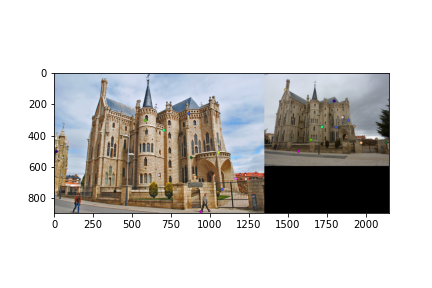

<IPython.core.display.Javascript object>


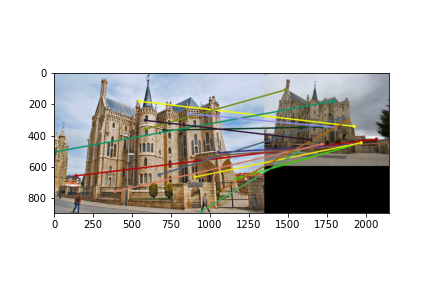

In [33]:
from proj3_code.utils import show_correspondence_circles, show_correspondence_lines
# num_pts_to_visualize = len(matches)
# array_ind = matches[:num_pts_to_visualize, 0]
# print(matches[:num_pts_to_visualize, 0], matches[:num_pts_to_visualize, 1])
# print(x1[1814], y1[1814], x2[1510], x2[1510])

num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
# plt.savefig('../results/vis_circles.jpg', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
# plt.savefig('../results/vis_lines.jpg', dpi=1000)

Comment out the function below if you are not testing on the Notre Dame, Episcopal Gaudi, and Mount Rushmore image pairs--this evaluation function will only work for those which have ground truth available.  
  
You can use `annotate_correspondences/collect_ground_truth_corr.py` to build the ground truth for other image pairs if you want, but it's very tedious. It would be a great service to the class for future years, though!

You found 15/100 required matches
Accuracy = 0.000000


<IPython.core.display.Javascript object>


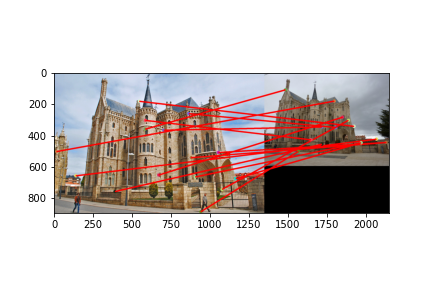

In [34]:
from proj3_code.utils import evaluate_correspondence
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
# plt.savefig('../results/eval.jpg', dpi=1000)

The above visualization should go into the report in the ground truth comparison section

## Extra credit
Extra credit for this project can be earned by doing the following:
- up to 2 pts: The simplest thing to do is to experiment with the numerous SIFT parameters: How big should each feature be? How many local cells should it have? How many orientations should each histogram have? Different normalization schemes can have a significant effect as well. Don’t get lost in parameter tuning though. Describe what you tried and the results in the appropriate extra credit section in the report.
- up to 4 pts: Speeding up the entire pipeline to be faster than our solution, while still meeeting the 80% accuracy requirement (vectorizing as much of the code as possible). For this you should put in your report what you did and the runtime. There will be a Gradescope test that automatically awards points for this section as part of the code. 
- up to 1 pts: Annotating and testing on your own images (provide visualizations as well). Put the results in the appropriate section of the report. 



## Rubric 
- 5 pts: Gradescope group quiz
- 25 pts: HarrisNet implementation in HarrisNet.py (6 total tests, with roughly even weighting)
- 25 pts: SIFTNet implementation in SIFTNet.py (7 total tests, with roughly even weighting)
- 10 pts: Feature matching implementation in student_feature_matching.py (2 total tests, with even weighting)
- 35 pts: PDF report
- -5*n pts: Lose 5 points for every time you do not follow the instructions for the hand-in format.

Given that there are multiple ways of successfully coding some of the functions, submissions that achieve an 80% accuracy on Notre Dame or higher will get full credit on the code portion.


## Submission
This is very important as you will lose 5 points for every time you do not follow the instructions.

Do install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that's not in there by default will probably cause your code to break during grading. Do use absolute paths in your code or your code will break. Use relative paths like the starter code already does. Failure to follow any of these instructions will lead to point deductions. Create the zip file using python zip_submission.py --gt_username <your_gt_username> (it will zip up the appropriate directories/files for you!) and hand it through Gradescope. Remember to submit your report as a PDF to Gradescope as well.

## Credit
Assignment developed by Vijay Upadhya, Sen Wang, Arvind Krishnakumar, and Frank Dellaert based on the original assignment by Cusuh Ham, John Lambert, Patsorn Sangkloy, Vijay Upadhya, Samarth Brahmbhatt, Frank Dellaert, and James Hays based on a similar project by Derek Hoiem.